###setup amalearn lib

In [1]:
! rm -r -f amalearn

In [2]:
! unzip amalearn-0.1.zip

Archive:  amalearn-0.1.zip
   creating: amalearn/
   creating: amalearn/.git/
  inflating: amalearn/.git/description  
   creating: amalearn/.git/hooks/
  inflating: amalearn/.git/hooks/applypatch-msg.sample  
  inflating: amalearn/.git/hooks/commit-msg.sample  
  inflating: amalearn/.git/hooks/fsmonitor-watchman.sample  
  inflating: amalearn/.git/hooks/post-update.sample  
  inflating: amalearn/.git/hooks/pre-applypatch.sample  
  inflating: amalearn/.git/hooks/pre-commit.sample  
  inflating: amalearn/.git/hooks/pre-merge-commit.sample  
  inflating: amalearn/.git/hooks/pre-push.sample  
  inflating: amalearn/.git/hooks/pre-rebase.sample  
  inflating: amalearn/.git/hooks/pre-receive.sample  
  inflating: amalearn/.git/hooks/prepare-commit-msg.sample  
  inflating: amalearn/.git/hooks/update.sample  
   creating: amalearn/.git/info/
  inflating: amalearn/.git/info/exclude  
   creating: amalearn/.git/refs/
   creating: amalearn/.git/refs/heads/
  inflating: amalearn/.git/refs/heads/

In [3]:
! pip install -e ./amalearn

Obtaining file:///content/amalearn
  Found existing installation: amalearn 0.1
    Can't uninstall 'amalearn'. No files were found to uninstall.
  Running setup.py develop for amalearn


###inherit from agent

In [4]:
import numpy as np
import operator
from amalearn.agent import AgentBase

class ThompsonAgent(AgentBase):
    def __init__(self, id, environment):
        super(ThompsonAgent, self).__init__(id, environment)
        self.act_num = self.environment.available_actions()
        self.p0 = 0.0001  # precision
        self.m0 = 0       # mean
        self.actions_estimation = dict(zip(range(self.act_num),\
                                           [[self.m0, self.p0] for i in range(self.act_num)]))
        self.length = 0
        self.trial = {}
        print(self.actions_estimation)
    
    def reset(self):
        self.actions_estimation = dict(zip(range(self.act_num),\
                                           [[self.m0, self.p0] for i in range(self.act_num)]))
        self.length = 0
        self.trial = {}
        print(self.actions_estimation)

    def update_estimation(self, action, r):
        # we know var of data is 1
        self.actions_estimation[action][0] +=\
          ((1/float(1+self.actions_estimation[action][1]))*(r-self.actions_estimation[action][0]))
        self.actions_estimation[action][1] += 1

        self.trial[self.length] = (action, r)
        self.length += 1

    def select_action(self):
        sample = {}
        for i in self.actions_estimation.keys():
          sample[i] = np.random.normal(\
                            self.actions_estimation[i][0],np.sqrt(1/self.actions_estimation[i][1]),1)
        return max(sample.items(), key=operator.itemgetter(1))[0]

    def get_stat(self):
        return self.trial

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, i = self.environment.step(action)
        self.update_estimation(action, r)
        print(obs, r, d, i)
        self.environment.render()
        return obs, r, d, i


###simulate action, agent and env

In [5]:
import numpy as np

from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.reward import GaussianReward
from amalearn.agent import RandomBanditAgent

means = [0.2, -0.8, 1.4, 0.4, 1, -1.5, -0.2, -1, 0.9, -0.4]
stds = [1 for i in means]

rewards = [GaussianReward(mean, std) for mean, std in zip(means, stds)]
env = MutliArmedBanditEnvironment(rewards, 1000, '1')
agent = ThompsonAgent('1', env)

data = []

for run in range(20):
  print('run: ',run)
  for step in range(1000):
      agent.take_action()
  data.append(agent.get_stat())
  env.reset()
  agent.reset()

Streaming output truncated to the last 5000 lines.
503:	action=2
{} 0.3055886082461984 False {}
504:	action=3
{} 2.434207604690787 False {}
505:	action=2
{} 2.5160041260021084 False {}
506:	action=2
{} 2.333782986629629 False {}
507:	action=2
{} 2.418893809412984 False {}
508:	action=2
{} 1.632134873927126 False {}
509:	action=2
{} 1.8315362112967142 False {}
510:	action=2
{} 0.5155966370480115 False {}
511:	action=2
{} 2.267764409830601 False {}
512:	action=2
{} 3.781615786511726 False {}
513:	action=2
{} 0.3036116660599204 False {}
514:	action=2
{} 1.2362342531103743 False {}
515:	action=2
{} 2.4419890762704997 False {}
516:	action=2
{} 0.3874376898384655 False {}
517:	action=2
{} 1.6051637090430417 False {}
518:	action=2
{} 1.2801469584081748 False {}
519:	action=2
{} 0.9809571036000913 False {}
520:	action=2
{} 0.0276092659125855 False {}
521:	action=2
{} 1.5181992293560753 False {}
522:	action=2
{} 2.602237983414029 False {}
523:	action=2
{} 1.1975317157992078 False {}
524:	action

### draw regret

In [6]:
def draw_list(data, xlabel, ylabel):
  plt.plot(range(len(data)), data)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.grid()

89.20191036747511


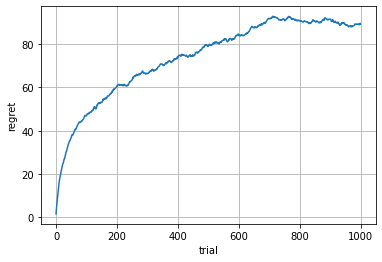

In [7]:
import matplotlib.pyplot as plt

def regret_per_run(data, best_action_mean, h):
    sum = 0
    for i in data.keys():
      if i > (h-1):
        break
      sum += data[i][1]
    return h*best_action_mean-sum

def regret(data, max_mean):
  regret_list = []
  for run in data:
    run_regret = []
    for j in range(len(run.keys())):
      run_regret.append(regret_per_run(run, max_mean, j+1))
    regret_list.append(run_regret)

  return regret_list

mean_regret = np.mean(np.array(regret(data, max(means))), axis=0)
draw_list(mean_regret, 'trial', 'regret')
print(mean_regret[-1])

###draw optimal action %

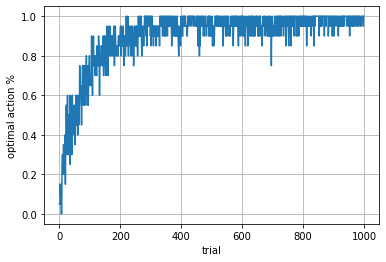

In [8]:
def optimal_action_ratio(data, opta):
  res = []
  trial_num = len(data[0].keys())

  for j in range(trial_num):
    temp = []
    for i in data:
      temp.append(i[j][0])
    res.append((temp.count(opta))/len(temp))
  
  return res

opta = np.argmax(np.array(means))
opta_per = optimal_action_ratio(data, opta)
draw_list(opta_per, 'trial', 'optimal action %')